In [10]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt
from ase.units import Bohr
import pandas as pd

In [79]:
class BDE():
    """
    fit binding energies to different models
    """
    def __init__(self,bfe, bde, ebfe, nbfe, Z1, Z2, xdata):
        self.bfe = bfe
        self.bde = bde
        self.ebfe = ebfe
        self.nbfe = nbfe
        self.ebde = -ebfe
        self.nbde = -nbfe
        self.Z1 = Z1
        self.Z2 = Z2
        self.xdata = xdata
        
    @classmethod
    def fromdict(cls, datadict):
        # get units
        if 'unit' in datadict.keys():
            e_unit = datadict['unit']
        else:
            e_unit = 1 # use Hartree as energy unit
            
        # bond energy
        bfe = np.array(datadict['bfe'])*e_unit # homolytic set to default
        bde = -bfe
        
        # nuclear charges
        Z1 = np.array(datadict['Z1'])
        Z2 = np.array(datadict['Z2'])
        
        # nuclear repulsion
        if 'nbfe' in datadict.keys():
            nbfe = np.array(datadict['nbfe'])*e_unit
        else:
            nbfe = Z1*Z2*e_unit
            
        # electronic bond energy
        ebfe = bfe - nbfe
        
        # xdata
        xdata = np.array([Z1, Z2]).T
        return(cls(bfe, bde, ebfe, nbfe, Z1, Z2, xdata))
    
    def linear_fit(self):
        self.linear_params, mae_waste, self.linear_rank, self.linear_sg = np.linalg.lstsq(self.get_coeff_mat(), self.bde-self.nbde, rcond=None)
        self.ebde_fitted = self.linear_params@self.coeff_mat.T
        # self.bfe_fitted = self.ebfe_fitted + self.nbfe
        self.bde_fitted = self.ebde_fitted + self.nbde
        self.linear_mae = np.abs(self.bde_fitted - self.bde).mean()
    
    def get_coeff_mat(self):
        """
        matrix with coefficients for linear fit
        """
        
        unique_Z = np.sort(np.unique(np.concatenate((self.Z1, self.Z2))))
        index_a = dict(zip(unique_Z, np.arange(len(unique_Z))))
        index_b = dict(zip(unique_Z, np.arange(len(unique_Z), 2*len(unique_Z))))
        coeff_mat = np.zeros((len(self.Z1), 2*len(unique_Z))) # there are two parameters for every element
        
        for row, Z1, Z2 in zip(range(len(self.Z1)), self.Z1, self.Z2):
            # coefficients for Z1
            coeff_mat[row, index_a[Z1]] += 1
            coeff_mat[row, index_b[Z1]] += Z2
            # coefficients for Z2
            coeff_mat[row, index_a[Z2]] += 1
            coeff_mat[row, index_b[Z2]] += Z1
            
        self.coeff_mat = coeff_mat
        return(self.coeff_mat)

    def non_linear_fit(self, model, p0 = None):
        if p0 is not None:
            self.params = curve_fit(model, self.xdata, self.bde, p0, maxfev=100000)
        else:
            self.params = curve_fit(model, self.xdata, self.bde)
        
        self.bde_fitted = model(self.xdata, *self.params[0])
        # self.bde_fitted = self.ebde_fitted + self.nbde
        self.mae = np.abs(self.bde_fitted-self.bde).mean()

### load data

In [ ]:
data = pd.read_csv('./binding_energies_pbe0.csv')

data_2 = data.loc[(data['Z1'] >= 6) & (data['Z1'] <= 9) & (data['Z2'] >= 6) & (data['Z2'] <= 9)].to_dict('list')
data_3 = data.loc[(data['Z1'] >= 14) & (data['Z2'] >= 14) & (data['Z1'] <= 17) & (data['Z2'] <= 17)].to_dict('list')
data_4 = data.loc[(data['Z1'] >= 32) & (data['Z2'] >= 32) & (data['Z1'] <= 35) & (data['Z2'] <= 35)].to_dict('list')

for d in [data_2, data_3, data_4]:
    d['unit'] = 630
    d['bfe type'] = 'homo'
    # nuclear repulsion contribution to binding energy
    d_bohr = (np.array(d['d'])/Bohr).mean()
    d['nbfe'] = np.array(d['Z1'])*np.array(d['Z2'])/d_bohr

### Optimize parameters of linear model Eq. (12)


In [ ]:
b2 = BDE.fromdict(data_2)
b3 = BDE.fromdict(data_3)
b4 = BDE.fromdict(data_4)
for b in [b2, b3, b4]:
    b.linear_fit()
    rounded_MAE = np.round((np.abs(b.bde-b.bde_fitted)).mean(),2)
    rounded_MAE_std = np.round(rounded_MAE/b.bde.std(), 2)
    print(f'MAE = {rounded_MAE} ({rounded_MAE_std})')

In [ ]:
# parameters of the model
for b in [b2, b3, b4]:
    print('###############')
    print(np.round(b.linear_params,2)[:4])
    print(np.round(b.linear_params,2)[4:])

### Optimize parameters of Eq. (18)


In [ ]:
def non_linear_model_eq18(var, a, b, c):
    Z1, Z2 = var.T
    bde = a**2 - b**2*Z1*Z2 + c**2*(Z1**(gamma)+Z2**(gamma))
    return(bde)

#### individually optimized $\gamma$ for each row

In [ ]:
b2_nl = BDE.fromdict(data_2)
b3_nl = BDE.fromdict(data_3)
b4_nl = BDE.fromdict(data_4)


p2 = [15, 24,  1.9]
p3 = [19.81710356, 24.92342986,  1.22294599]
p4 = [33.3052603 , 24.97639216,  0.90171214]

maes = []
for gamma in np.linspace(0.5, 4, 50):
    mae_row = []
    for b, p0 in zip([b2_nl, b3_nl, b4_nl], [p2, p3, p4]):

        b.non_linear_fit(non_linear_model_eq18, p0=p0)
        rounded_MAE = np.round((np.abs(b.bde-b.bde_fitted)).mean(),2)
        rounded_MAE_std = np.round(rounded_MAE/b.bde.std(), 2)
        mae_row.append((np.abs(b.bde-b.bde_fitted)).mean())
    maes.append(mae_row)

#### $\gamma$-exponent independent of the row

In [ ]:
gammas = []
MAEs= []
# do non linear fits
b2_nl = BDE.fromdict(data_2)
b3_nl = BDE.fromdict(data_3)
b4_nl = BDE.fromdict(data_4)
for gamma in np.linspace(0.5, 4, 50):
    overall_mae = []
    
    p2 = [15, 24,  1.9]
    p3 = [19.81710356, 24.92342986,  1.22294599]
    p4 = [33.3052603 , 24.97639216,  0.90171214]
    
    for b, p0 in zip([b2_nl, b3_nl, b4_nl], [p2, p3, p4]):

        b.non_linear_fit(non_linear_model_eq18, p0=p0)
        #print('MAE = ' + str((np.abs(b.bde-b.bde_fitted)).mean()))
        rounded_MAE = np.round((np.abs(b.bde-b.bde_fitted)).mean(),2)
        rounded_MAE_std = np.round(rounded_MAE/b.bde.std(), 2)
#         print(f'MAE = {rounded_MAE} ({rounded_MAE_std})')
        overall_mae.append((np.abs(b.bde-b.bde_fitted)).mean())
    MAE = (np.array(overall_mae)).mean()
    #print(f'gamma = {gamma}, MAE = {MAE}')
    
    gammas.append(gamma)
    MAEs.append(MAE)

In [ ]:
gamma_val = np.linspace(0.5, 4, 50)
fig, ax = plt.subplots(1,1)
ax.plot(gamma_val, np.array(maes)[:,0], label = 'row 2')
ax.plot(gamma_val, np.array(maes)[:,1], label = 'row 3')
ax.plot(gamma_val, np.array(maes)[:,2], label = 'row 4')

ax.plot(gammas, MAEs, '--', label = 'all rows')

ax.vlines(7/3, 0.8, 10, linestyles = '--', linewidth = 1, color= 'tab:gray')
ax.legend(frameon= False, bbox_to_anchor = (1.05,1))
ax.set_ylim([0.8, 10.4])
ax.set_xticks([1,2,7/3,3,4])
ax.set_xticklabels(['1','2','7/3','3','4'])
ax.set_xlabel(r'$\gamma$')
ax.set_ylabel('MAE (kcal/mol)')

### Optimization parameters of our model Eq. (2)

In [ ]:
def our_model_eq2(var, a, b, c):
    Z1, Z2 = var.T
    gamma = 7/3
    bde = a**2 - b**2*Z1*Z2 + c**2*(Z1**(gamma)+Z2**(gamma))
    return(bde)

# do linear fits
b2_nl = BDE.fromdict(data_2)
b3_nl = BDE.fromdict(data_3)
b4_nl = BDE.fromdict(data_4)

for b in [b2_nl, b3_nl, b4_nl]:
    b.non_linear_fit(our_model_eq2, p0 = [33.3052603 , 24.97639216,  0.90171214])
    #print('MAE = ' + str((np.abs(b.bde-b.bde_fitted)).mean()))
    rounded_MAE = np.round((np.abs(b.bde-b.bde_fitted)).mean(),2)
    rounded_MAE_std = np.round(rounded_MAE/b.bde.std(), 2)
    print(f'MAE = {rounded_MAE} ({rounded_MAE_std})')

In [ ]:
a_param = []
b_param =[]
c_param=[]
for b in [b2_nl, b3_nl, b4_nl]:
    a_param.append(b.params[0][0])
    b_param.append(b.params[0][1])
    c_param.append(b.params[0][2])
    
a_param = np.array(a_param)**2
b_param =np.array(b_param)**2
c_param=np.array(c_param)**2
print(a_param)
print(b_param)
print(c_param)

### Optimization of parameters in Eq. (25)

In [2]:
def model_deltaE_eq7(var, eta, kappa, mu):
    ZA, ZB, ZC, n = var.T
    deltaZ = ZC - ZB
    deltaE = ( eta*(n-1) + ((n-3)**2 + kappa)*ZA )*deltaZ + mu*(ZB**2-ZC**2)
    return(deltaE)

In [3]:
data = pd.read_csv('./binding_energies_pbe0.csv')

Z_ref_dict = {2:[6,7,8,9], 3:[14,15,16,17], 4:[32,33,34,35]}

# calculate relative energies for reference data
# collect tuples Z_ABC: (ZA, ZB, ZC, row_number)
Z_ABC = []
deltaE_ref = []
for n in [2,3,4]:
    Z_ref = Z_ref_dict[n]
    for ZA in Z_ref:
            for ZB in Z_ref:
                for ZC in Z_ref:
                    if ZB<ZC:
                        if ZA <= ZB:
                            E_AB = -630*data.loc[(data['Z1']==ZA) & (data['Z2']==ZB), 'bfe'].item()
                        else:
                            E_AB = -630*data.loc[(data['Z1']==ZB) & (data['Z2']==ZA), 'bfe'].item()
                        if ZA <= ZC:
                            E_AC = -630*data.loc[(data['Z1']==ZA) & (data['Z2']==ZC), 'bfe'].item()
                        else:
                            E_AC = -630*data.loc[(data['Z1']==ZC) & (data['Z2']==ZA), 'bfe'].item()

                        Z_ABC.append([ZA, ZB, ZC, n])
                        deltaE_ref.append(E_AB - E_AC)

Z_ABC = np.array(Z_ABC)
deltaE_ref = np.array(deltaE_ref)

In [5]:
# fit
p0 = [1,1,1]
out = curve_fit(model_deltaE_eq7, Z_ABC, deltaE_ref, p0)
print(out[0])

deltaE_fitted = model_deltaE_eq7(Z_ABC, *out[0])
mae = (np.abs(deltaE_fitted-deltaE_ref)).mean()
print(f'MAE = {mae} kcal/mol')

[27.46471278  7.73446031  5.5672527 ]
MAE = 4.263142705925952 kcal/mol


In [8]:
# choose integer coefficicients in range of optimal coefficients
deltaE_fitted = model_deltaE_eq7(Z_ABC, 28, 8.5, 6)
mae = (np.abs(deltaE_fitted-deltaE_ref)).mean()
print(f'MAE = {mae} kcal/mol')

MAE = 4.227588540816827 kcal/mol


### Recalibration to binding energies of double bonds

In [66]:
def our_model_eq2(var, a, b, c):
    Z1, Z2 = var.T
    gamma = 7/3
    bde = a**2 - b**2*Z1*Z2 + c**2*(Z1**(gamma)+Z2**(gamma))
    return(bde)

In [69]:
for row in [2,3,4]:
    print('############################')
    print(f'Row {row}')
    for etype in ['bde_TS', 'bde_GS', 'bde_TT', 'bde_SS']:
        dataframe = pd.read_csv(f'./binding_energies_db_row_{row}.csv')
        datadict = {'Z1':dataframe['Z1'].to_numpy(), 'Z2':dataframe['Z2'].to_numpy(), 'bfe':-dataframe[etype].to_numpy(), 'unit':630}

        db = BDE.fromdict(datadict)
        db.non_linear_fit(our_model_eq2, p0 = [15,3.16,1.41])
        print(f'Energy difference: {etype}: MAE = {db.mae} kcal/mol')

############################
Row 2
Energy difference: bde_TS: MAE = 0.9476184941805906 kcal/mol
Energy difference: bde_GS: MAE = 7.390428721398692 kcal/mol
Energy difference: bde_TT: MAE = 7.295680777124287 kcal/mol
Energy difference: bde_SS: MAE = 8.167122911261155 kcal/mol
############################
Row 3
Energy difference: bde_TS: MAE = 1.3468270017713664 kcal/mol
Energy difference: bde_GS: MAE = 1.5587564014477333 kcal/mol
Energy difference: bde_TT: MAE = 13.761890884085757 kcal/mol
Energy difference: bde_SS: MAE = 12.874242572636176 kcal/mol
############################
Row 4
Energy difference: bde_TS: MAE = 1.9770280951557144 kcal/mol
Energy difference: bde_GS: MAE = 1.8884093806738527 kcal/mol
Energy difference: bde_TT: MAE = 10.454982961217143 kcal/mol
Energy difference: bde_SS: MAE = 12.564665065686148 kcal/mol


/home/sahre/opt/miniconda3/envs/qm-tools/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


### Performance of model for random data (Section F)

In [80]:
from scipy.stats import linregress

def our_model_eq2(var, a, b, c):
    Z1, Z2 = var.T
    gamma = 7/3
    bde = a**2 - b**2*Z1*Z2 + c**2*(Z1**(gamma)+Z2**(gamma))
    return(bde)

# fit random set of points from uniform distribution to our model
def error_random2(model, N, shift):
    """
    the function picks 6 random data points from a uniform distribution in the same energy range as model
    and optimizes the parameters of our model Eq. (2) to this dataset
    this procedures is repeated N times and the errors for all N datasets are returned
    model: BDE object for certain energy difference (TS, GS, ...)
    """
    low = (model.bde).mean()-shift
    high = (model.bde).mean()+shift

    errors = []
    for n in range(N):

        control_energy = (np.random.uniform(low=low, high=high, size=6))/630
        control_data = {'smiles': ['CC', 'CN', 'CO', 'NN', 'NO', 'OO'],
         'Z1': model.Z1,
         'Z2': model.Z2,
         'bfe': -control_energy,
         'unit': 630,
         'bfe type': 'homo'}

        control = BDE.fromdict(control_data)
        control.non_linear_fit(our_model_eq2, p0 = [1,1,1])
        errors.append((np.abs(control.bde_fitted-control.bde)).mean())

    errors = np.array(errors)
    return(errors)

In [81]:
row = 2
etype = 'bde_TS'
dataframe = pd.read_csv(f'./binding_energies_db_row_{row}.csv')
datadict = {'Z1':dataframe['Z1'].to_numpy(), 'Z2':dataframe['Z2'].to_numpy(), 'bfe':-dataframe[etype].to_numpy(), 'unit':630}

db = BDE.fromdict(datadict)

In [88]:
N = 1000
bde_range = np.arange(0, 130, 30)
errors = []
for shift in bde_range:
    errors.append(error_random2(db, N, shift))
    
mean_errors = []
std_errors = []
for e in errors:
    mean_errors.append(e.mean())
    std_errors.append(e.std())
out = linregress(bde_range, mean_errors)
out_std = linregress(bde_range, std_errors)

/home/sahre/opt/miniconda3/envs/qm-tools/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


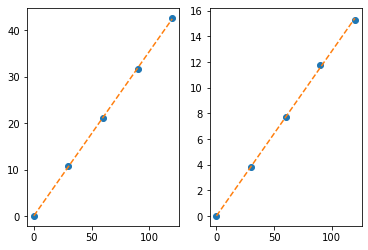

In [87]:
fig, ax = plt.subplots(1,2)
ax[0].plot(bde_range, mean_errors, 'o')
ax[0].plot(bde_range, bde_range*out[0]+out[1], '--')

ax[1].plot(bde_range, std_errors, 'o')
ax[1].plot(bde_range, bde_range*out_std[0]+out_std[1], '--')

In [89]:
def error_uni_model(models, out, out_std, bde_range):
    fig, ax = plt.subplots(1,1)
    ax.plot(bde_range, bde_range*out[0]+out[1], '--', color = 'tab:gray')

    labels = ['TS', 'GS', 'TT', 'SS']
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

    for model,l , c in zip(models,labels, colors):
        deltaE = np.amax(model.bde)-np.amin(model.bde)
        mae = (np.abs(model.bde-model.bde_fitted)).mean()
        ax.scatter(deltaE, deltaE*out[0]+out[1], color = c)
        ax.errorbar(deltaE, deltaE*out[0]+out[1], yerr=deltaE*out_std[0]+out_std[1], color = c)
        ax.scatter(deltaE, mae, marker = 'v', label = l, color = c)
    ax.legend(frameon = False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel(r'$E^{\rm{max}}_{\rm{AB}}-E^{\rm{min}}_{\rm{AB}}$ (kcal/mol)')
    ax.set_ylabel(r'MAE (kcal/mol)')
    return(fig, ax)

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='$E^{\\rm{max}}_{\\rm{AB}}-E^{\\rm{min}}_{\\rm{AB}}$ (kcal/mol)', ylabel='MAE (kcal/mol)'>)

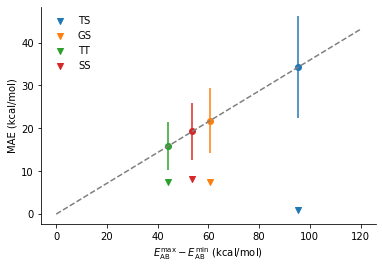

In [91]:
row = 2
energy_differences = []
for etype in ['bde_TS', 'bde_GS', 'bde_TT', 'bde_SS']:
    dataframe = pd.read_csv(f'./binding_energies_db_row_{row}.csv')
    datadict = {'Z1':dataframe['Z1'].to_numpy(), 'Z2':dataframe['Z2'].to_numpy(), 'bfe':-dataframe[etype].to_numpy(), 'unit':630}

    db = BDE.fromdict(datadict)
    db.non_linear_fit(our_model_eq2, p0 = [15,3.16,1.41])
    energy_differences.append(db)
error_uni_model(energy_differences, out, out_std, bde_range)


(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='$E^{\\rm{max}}_{\\rm{AB}}-E^{\\rm{min}}_{\\rm{AB}}$ (kcal/mol)', ylabel='MAE (kcal/mol)'>)

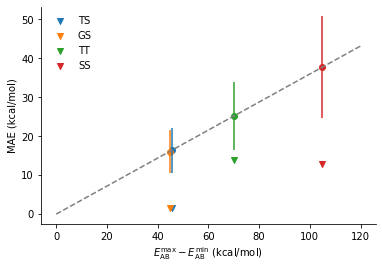

In [92]:
row = 3
energy_differences = []
for etype in ['bde_TS', 'bde_GS', 'bde_TT', 'bde_SS']:
    dataframe = pd.read_csv(f'./binding_energies_db_row_{row}.csv')
    datadict = {'Z1':dataframe['Z1'].to_numpy(), 'Z2':dataframe['Z2'].to_numpy(), 'bfe':-dataframe[etype].to_numpy(), 'unit':630}

    db = BDE.fromdict(datadict)
    db.non_linear_fit(our_model_eq2, p0 = [15,3.16,1.41])
    energy_differences.append(db)
error_uni_model(energy_differences, out, out_std, bde_range)


/home/sahre/opt/miniconda3/envs/qm-tools/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='$E^{\\rm{max}}_{\\rm{AB}}-E^{\\rm{min}}_{\\rm{AB}}$ (kcal/mol)', ylabel='MAE (kcal/mol)'>)

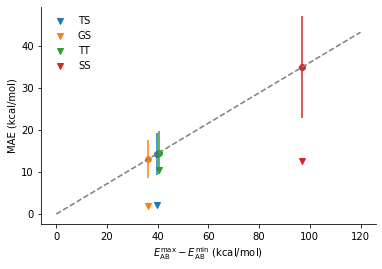

In [94]:
row = 4
energy_differences = []
for etype in ['bde_TS', 'bde_GS', 'bde_TT', 'bde_SS']:
    dataframe = pd.read_csv(f'./binding_energies_db_row_{row}.csv')
    datadict = {'Z1':dataframe['Z1'].to_numpy(), 'Z2':dataframe['Z2'].to_numpy(), 'bfe':-dataframe[etype].to_numpy(), 'unit':630}

    db = BDE.fromdict(datadict)
    db.non_linear_fit(our_model_eq2, p0 = [15,3.16,1.41])
    energy_differences.append(db)
error_uni_model(energy_differences, out, out_std, bde_range)
